In [1]:
import os
os.chdir("/Users/nuraisha/Desktop/chasingflights")

In [2]:
# importing data
import pandas as pd
Y1995 = pd.read_csv("1995.csv", encoding='latin-1')
Y1996 = pd.read_csv("1996.csv", encoding='latin-1')
Y2000 = pd.read_csv("2000.csv", encoding='latin-1')
Y2001 = pd.read_csv("2001.csv", encoding='latin-1')
Y2002 = pd.read_csv("2002.csv", encoding='latin-1')
Y2006 = pd.read_csv("2006.csv", encoding='latin-1')
Y2007 = pd.read_csv("2007.csv", encoding='latin-1')

# collating data into one
database = pd.concat([Y1995, Y1996, Y2000, Y2001, Y2002, Y2006, Y2007])

In [3]:
database.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42196741 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           float64
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay     

In [4]:
# drop columns
database.drop(database.columns[[10, 11, 12, 13, 18, 19, 20, 22, 24, 25, 26, 27, 28]], axis=1, inplace=True)

# check for NA values
database.isna().sum()

Year                   0
Month                  0
DayofMonth             0
DayOfWeek              0
DepTime           986954
CRSDepTime             0
ArrTime          1080451
CRSArrTime             0
UniqueCarrier          0
FlightNum              0
ArrDelay         1080451
DepDelay          986954
Origin                 0
Dest                   0
Cancelled              0
Diverted               0
dtype: int64

In [5]:
# removing rows with NA values
database = database.dropna()

#### **1. Finding the Optimal Schedule**

In [6]:
# filtering the data
nondel = database[(database['ArrDelay']<= 15) & 
                  (database['DepDelay']<= 15)]

# selecting relevant columns
sched = nondel[['Month', 'DayOfWeek', 'CRSDepTime']]

# finding frequency of each schedule combination
schedfreq = sched.groupby(['Month', 'DayOfWeek', 'CRSDepTime']).size().reset_index(name='Frequency')

# finding top 3 values by frequency
top_sched = schedfreq.nlargest(3, 'Frequency')
top_sched

,Month,DayOfWeek,CRSDepTime,Frequency
36415,5,3,700,9131
77239,10,2,700,8684
35212,5,2,700,8620


#### **2. Efficiency of Older Planes**

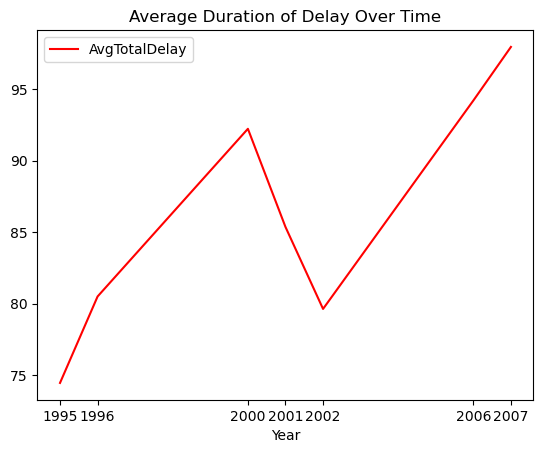

In [7]:
# Filtering the data and making a copy to avoid SettingWithCopyWarning
del_flights = database[(database['ArrDelay'] > 15) | (database['DepDelay'] > 15)].copy()

# Finding total delay
del_flights['TotalDelay'] = del_flights[['ArrDelay', 'DepDelay']].sum(axis=1)

# Finding average delay per year
avgdel_year = del_flights.groupby('Year')['TotalDelay'].mean().reset_index().rename(columns={'TotalDelay': 'AvgTotalDelay'})

# Plotting
from matplotlib import pyplot as plt
avgdel_year.plot(x='Year', y='AvgTotalDelay', color='red')
plt.title('Average Duration of Delay Over Time')
plt.xticks(avgdel_year['Year'])
plt.show()


#### **3. Flight Destinations**

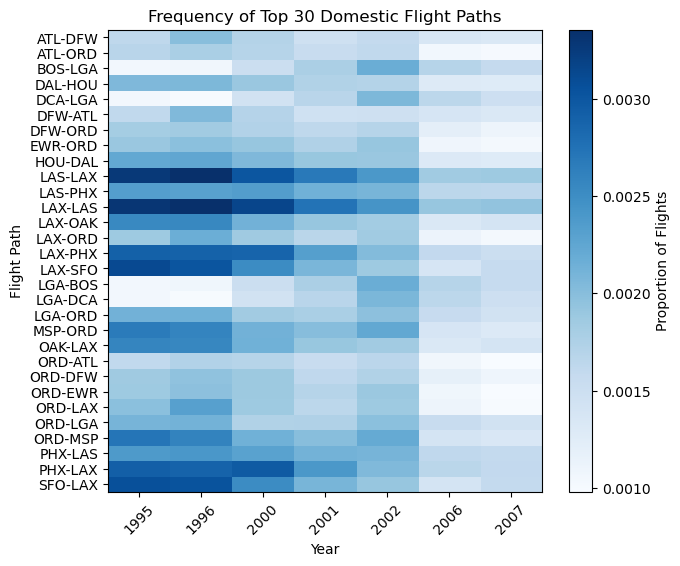

In [8]:
# Filter data
flightpath = database[(database['Cancelled'] == 0) & (database['Diverted'] == 0)]

# Finding frequency of paths
freq_flights = flightpath.groupby(['Origin', 'Dest', 'Year']).size().reset_index(name='counts')
freq_flights['Flight'] = freq_flights['Origin'] + "-" + freq_flights['Dest']

# New column for total observations each year
totalobs_year = pd.DataFrame(flightpath['Year'].value_counts().reset_index(name='total')).rename(columns={'index': 'Year'})
newdf = pd.merge(freq_flights, totalobs_year, on='Year', how="left")

# Finding proportion
newdf['proportion'] = newdf['counts'] / newdf['total']

# Finding the list of top 30 flight paths
sumflights = flightpath[['Origin', 'Dest']].value_counts().reset_index(name='counts')
sumflights['Flight'] = sumflights['Origin'] + "-" + sumflights['Dest']
toppaths = list(sumflights.nlargest(30, 'counts')['Flight'])
freqtoppaths = newdf.query('Flight in @toppaths')

# Pivot table
pivot = freqtoppaths.pivot_table(index='Flight', columns='Year', values='proportion').fillna(0)

# Plot
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(7, 6))
plt.imshow(pivot, cmap='Blues', aspect='auto')
plt.colorbar(label="Proportion of Flights")

# Labeling
plt.yticks(np.arange(len(pivot.index)), labels=pivot.index)
plt.xticks(np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45)
plt.title("Frequency of Top 30 Domestic Flight Paths")
plt.xlabel("Year")
plt.ylabel("Flight Path")
plt.show()


#### **4. Cascading Failure**

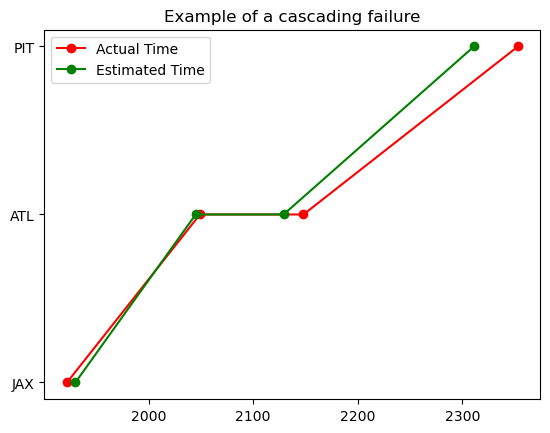

In [9]:
# data
del2007 = Y2007[(Y2007['ArrDelay'] > 15) | 
                       (Y2007['DepDelay'] > 15)]

# random sample
random_seed = 222
del2007.sample(n=1, random_state = random_seed)

E1 = Y2007[(Y2007['FlightNum'] == 1442) & (Y2007['TailNum'] == 'N987DL')
          & (Y2007['Month'] == 1) & (Y2007['DayofMonth'] == 28)]
E1

act_arrtime = E1[['Dest', 'ArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'ArrTime' : 'Time'})
act_deptime = E1[['Origin', 'DepTime']].rename(columns={'Origin' : 'Airport',
                                                 'DepTime' : 'Time'})
act_time = (pd.concat([act_arrtime, act_deptime])).sort_values(by=['Time'])

est_arrtime = E1[['Dest', 'CRSArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'CRSArrTime' : 'Time'})
est_deptime = E1[['Origin', 'CRSDepTime']].rename(columns={'Origin' : 'Airport',
                                                 'CRSDepTime' : 'Time'})
est_time = (pd.concat([est_arrtime, est_deptime])).sort_values(by=['Time'])

#graph
plt.plot(act_time['Time'], act_time['Airport'], linestyle = '-',
         marker = 'o', color = 'red', label='Actual Time')
plt.plot(est_time['Time'], est_time['Airport'], linestyle = '-',
         marker = 'o', color = 'green', label='Estimated Time')
plt.title('Example of a cascading failure')
plt.legend()
plt.show()

In [10]:
# random sample
random_seed = 11
a = del2007.sample(n=1, random_state = random_seed)
a

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
7003561,2007,12,15,6,1915.0,1645,2002.0,1740,OH,5543,...,7,14,0,NaN,0,0,0,0,0,142


In [11]:
a['TailNum']

7003561    N656CA
Name: TailNum, dtype: object

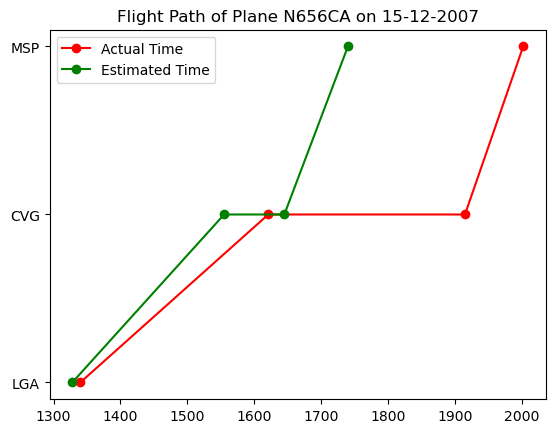

In [12]:
E2 = Y2007[(Y2007['FlightNum'] == 5543) & (Y2007['TailNum'] == 'N656CA')
          & (Y2007['Month'] == 12)]
E2

act_arrtime = E2[['Dest', 'ArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'ArrTime' : 'Time'})
act_deptime = E2[['Origin', 'DepTime']].rename(columns={'Origin' : 'Airport',
                                                 'DepTime' : 'Time'})
act_time = (pd.concat([act_arrtime, act_deptime])).sort_values(by=['Time'])

est_arrtime = E2[['Dest', 'CRSArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'CRSArrTime' : 'Time'})
est_deptime = E2[['Origin', 'CRSDepTime']].rename(columns={'Origin' : 'Airport',
                                                 'CRSDepTime' : 'Time'})
est_time = (pd.concat([est_arrtime, est_deptime])).sort_values(by=['Time'])

#graph
plt.plot(act_time['Time'], act_time['Airport'], linestyle = '-',
         marker = 'o', color = 'red', label='Actual Time')
plt.plot(est_time['Time'], est_time['Airport'], linestyle = '-',
         marker = 'o', color = 'green', label='Estimated Time')
plt.title('Flight Path of Plane N656CA on 15-12-2007')
plt.legend()
plt.show()

In [13]:
del2007.loc[:, 'FlightDate'] = pd.to_datetime(del2007[['Year', 'Month', 'DayofMonth']].rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}))

/var/folders/h6/0052p6fs5pl969xm6dnbpq_h0000gp/T/ipykernel_59217/2987083354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del2007.loc[:, 'FlightDate'] = pd.to_datetime(del2007[['Year', 'Month', 'DayofMonth']].rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}))


In [14]:
import pandas as pd

# Sort the DataFrame to ensure consecutive rows for each aircraft by date and time
df = del2007.sort_values(by=['TailNum', 'FlightDate', 'DepTime'])

# Step 1: Shift to create two levels of consecutive flights
df['Next1_Origin'] = df['Origin'].shift(-1)
df['Next1_Dest'] = df['Dest'].shift(-1)
df['Next1_TailNum'] = df['TailNum'].shift(-1)
df['Next1_FlightDate'] = df['FlightDate'].shift(-1)

df['Next2_Origin'] = df['Origin'].shift(-2)
df['Next2_Dest'] = df['Dest'].shift(-2)
df['Next2_TailNum'] = df['TailNum'].shift(-2)
df['Next2_FlightDate'] = df['FlightDate'].shift(-2)

# Step 2: Filter for sequences of 3 consecutive flights
three_flight_sequences = df[
    (df['Dest'] == df['Next1_Origin']) &
    (df['Next1_Dest'] == df['Next2_Origin']) &
    (df['TailNum'] == df['Next1_TailNum']) &
    (df['TailNum'] == df['Next2_TailNum']) &
    (df['FlightDate'] == df['Next1_FlightDate']) &
    (df['FlightDate'] == df['Next2_FlightDate'])
]

# Step 3: Drop helper columns if desired
three_flight_sequences = three_flight_sequences.drop(
    columns=['Next1_Origin', 'Next1_Dest', 'Next1_TailNum', 'Next1_FlightDate', 
             'Next2_Origin', 'Next2_Dest', 'Next2_TailNum', 'Next2_FlightDate']
)



In [15]:
three_flight_sequences.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 493422 entries, 468102 to 7164736
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Year               493422 non-null  int64         
 1   Month              493422 non-null  int64         
 2   DayofMonth         493422 non-null  int64         
 3   DayOfWeek          493422 non-null  int64         
 4   DepTime            493422 non-null  float64       
 5   CRSDepTime         493422 non-null  int64         
 6   ArrTime            492682 non-null  float64       
 7   CRSArrTime         493422 non-null  int64         
 8   UniqueCarrier      493422 non-null  object        
 9   FlightNum          493422 non-null  int64         
 10  TailNum            493422 non-null  object        
 11  ActualElapsedTime  492682 non-null  float64       
 12  CRSElapsedTime     493390 non-null  float64       
 13  AirTime            492682 non-null  fl

In [16]:
three_flight_sequences.drop(three_flight_sequences.columns[[11, 12, 13, 18, 19, 20, 22,
                                24, 25, 26, 27, 28]], axis=1, inplace=True)
three_flight_sequences

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,Diverted,FlightDate
468102,2007,1,4,4,1310.0,1310,1544.0,1522,9E,2857,80009E,22.0,0.0,MSP,OKC,0,0,2007-01-04
475174,2007,1,14,7,1030.0,1030,1249.0,1205,9E,5648,80009E,44.0,0.0,MSP,STL,0,0,2007-01-14
475781,2007,1,15,1,548.0,520,718.0,605,9E,4771,80009E,73.0,28.0,RST,MSP,0,0,2007-01-15
475780,2007,1,15,1,749.0,700,1103.0,959,9E,4771,80009E,64.0,49.0,MSP,CVG,0,0,2007-01-15
475702,2007,1,15,1,1120.0,1100,1226.0,1223,9E,3771,80009E,3.0,20.0,CVG,DTW,0,0,2007-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7163155,2007,12,29,6,1028.0,1010,1204.0,1145,DL,453,N999DN,19.0,18.0,ATL,AUS,0,0,2007-12-29
7164356,2007,12,30,7,716.0,715,1013.0,931,DL,456,N999DN,42.0,1.0,MEM,ATL,0,0,2007-12-30
7164357,2007,12,30,7,1102.0,1020,1238.0,1205,DL,456,N999DN,33.0,42.0,ATL,DCA,0,0,2007-12-30
7164361,2007,12,30,7,1315.0,1255,1525.0,1449,DL,463,N999DN,36.0,20.0,DCA,ATL,0,0,2007-12-30


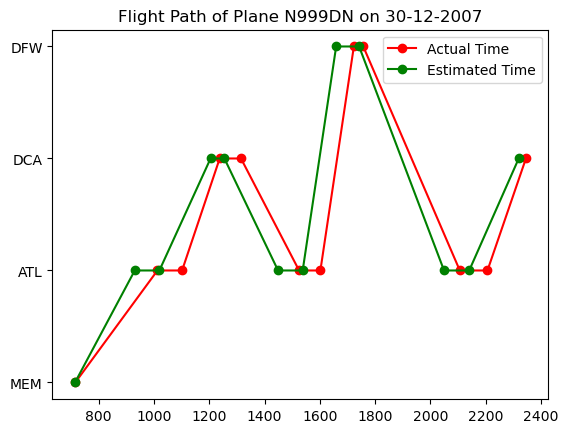

In [17]:
E2 = del2007[(del2007['TailNum'] == 'N999DN') & (del2007['FlightDate'] == '2007-12-30')]
E2

act_arrtime = E2[['Dest', 'ArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'ArrTime' : 'Time'})
act_deptime = E2[['Origin', 'DepTime']].rename(columns={'Origin' : 'Airport',
                                                 'DepTime' : 'Time'})
act_time = (pd.concat([act_arrtime, act_deptime])).sort_values(by=['Time'])

est_arrtime = E2[['Dest', 'CRSArrTime']].rename(columns={'Dest' : 'Airport', 
                                               'CRSArrTime' : 'Time'})
est_deptime = E2[['Origin', 'CRSDepTime']].rename(columns={'Origin' : 'Airport',
                                                 'CRSDepTime' : 'Time'})
est_time = (pd.concat([est_arrtime, est_deptime])).sort_values(by=['Time'])

#graph
plt.plot(act_time['Time'], act_time['Airport'], linestyle = '-',
         marker = 'o', color = 'red', label='Actual Time')
plt.plot(est_time['Time'], est_time['Airport'], linestyle = '-',
         marker = 'o', color = 'green', label='Estimated Time')
plt.title('Flight Path of Plane N999DN on 30-12-2007')
plt.legend()
plt.show()

In [18]:
import pandas as pd

# Sort the DataFrame to ensure proper sequence of flights
df = del2007.sort_values(by=['TailNum', 'FlightDate', 'DepTime'])

# Step 1: Create a 'FlightPath' column that represents each flight's origin and destination
df['FlightPath'] = df['Origin'] + " -> " + df['Dest']

# Step 2: Track consecutive flights for each plane
# Shift to get the next flight's details
df['Next_TailNum'] = df['TailNum'].shift(-1)
df['Next_Origin'] = df['Origin'].shift(-1)
df['Next_Dest'] = df['Dest'].shift(-1)
df['Next_FlightDate'] = df['FlightDate'].shift(-1)

# Step 3: Filter for consecutive flights of the same plane
consecutive_flights = df[
    (df['TailNum'] == df['Next_TailNum']) &
    (df['FlightDate'] == df['Next_FlightDate'])
]

# Optional: Create a column to show the full path of consecutive flights
consecutive_flights['FullPath'] = consecutive_flights['FlightPath'] + " -> " + consecutive_flights['Next_Dest']

# Step 4: Optionally, drop the helper columns
consecutive_flights = consecutive_flights.drop(columns=['Next_TailNum', 'Next_Origin', 'Next_Dest', 'Next_FlightDate'])

# Show the resulting DataFrame
print(consecutive_flights[['TailNum', 'FlightDate', 'FlightPath', 'FullPath']])


/var/folders/h6/0052p6fs5pl969xm6dnbpq_h0000gp/T/ipykernel_59217/4070934974.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consecutive_flights['FullPath'] = consecutive_flights['FlightPath'] + " -> " + consecutive_flights['Next_Dest']


        TailNum FlightDate  FlightPath           FullPath
3634723       0 2007-06-26  DLG -> ANC  DLG -> ANC -> JNU
5720827       0 2007-10-07  SAN -> GEG  SAN -> GEG -> ONT
6359109       0 2007-11-11  SEA -> LAX  SEA -> LAX -> LAX
6361119       0 2007-11-11  OAK -> LAX  OAK -> LAX -> LAX
6360879       0 2007-11-11  SJC -> LAX  SJC -> LAX -> LAX
...         ...        ...         ...                ...
7164736  N999DN 2007-12-30  ATL -> DFW  ATL -> DFW -> ATL
7164566  N999DN 2007-12-30  DFW -> ATL  DFW -> ATL -> DCA
6762979  NHZOAL 2007-11-18  SMF -> OGG  SMF -> OGG -> SMF
6762982  NHZOAL 2007-11-21  SMF -> OGG  SMF -> OGG -> SMF
7374319  NHZOAL 2007-12-30  OAK -> KOA  OAK -> KOA -> OAK

[1089022 rows x 4 columns]


#### **5. Predicting Delays**

In [19]:
import numpy as np # work with arrays
database['Delay'] = np.where((database['ArrDelay'] > 15) | (database['DepDelay'] > 15), 1, 0)
sample = database.sample(n=50000, replace=False)
target = sample['Delay']
features = sample.loc[:, sample.columns != 'Delay']

In [20]:
cat_attribs = list(features.select_dtypes(['object']))
cat_attribs

['UniqueCarrier', 'Origin', 'Dest']

In [21]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train, Y_test = train_test_split(features, target, test_size = 0.3, random_state = 13)

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

X_train = X_train1.copy()
X_train[cat_attribs] = encoder.fit_transform(X_train1[cat_attribs])

X_test = X_test1.copy()
X_test[cat_attribs] = encoder.fit_transform(X_test1[cat_attribs])

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,chi2

selected_features = []
selector = SelectKBest(f_regression, k = 'all')
selector.fit_transform(X_train, Y_train)

supports = selector.get_support()

print(supports)
print(features.columns)

for support, feature in zip(supports, features.columns):

  if (support == True):
    selected_features.append(feature)

print('Selected features are: ', selected_features)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Cancelled', 'Diverted'],
      dtype='object')
Selected features are:  ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Cancelled', 'Diverted']


In [23]:
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)
Y_train = np.ascontiguousarray(Y_train)
Y_test = np.ascontiguousarray(Y_test)

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, Y_train)

Y_pred = KNN.predict(X_test)

accuracy_KNN = round(metrics.accuracy_score(Y_test, Y_pred)*100, 2)
print('Accuracy of KNN is', accuracy_KNN)

Accuracy of KNN is 84.14


In [24]:
# SVM
from sklearn import linear_model, neighbors, tree, svm, ensemble
from sklearn.model_selection import GridSearchCV

svm_clf = svm.SVC(kernel="poly")

param_grid = {"degree" : [0,1,2, 3, 4, 5],
              "coef0" : [0,1],  #the intercept of polynomial transformation
              'C' : [0.001, 0.01, 0.1, 1, 10, 100]}

gs_clf = GridSearchCV(svm_clf, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs_clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'coef0': [0, 1],
                         'degree': [0, 1, 2, 3, 4, 5]},
             scoring='accuracy')

In [25]:
svm_clf = gs_clf.best_estimator_
svm_clf.fit(X_train, Y_train)

print('train_acc:', svm_clf.score(X_train, Y_train),
      '\n test_acc:', svm_clf.score(X_test, Y_test))

train_acc: 0.9731428571428572 
 test_acc: 0.9714666666666667


In [26]:
from sklearn import metrics

# Get predictions on the test set
Y_pred_svm = svm_clf.predict(X_test)

# Calculate accuracy
accuracy_svm = round(metrics.accuracy_score(Y_test, Y_pred_svm) * 100, 2)
print('Accuracy of SVM is', accuracy_svm)


Accuracy of SVM is 97.15
